In [1]:
import pandas as pd
import numpy as np
import load_utils as lu
import metrics_utils as mu
import sys
import os
import datetime
from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio filesrom IPython.display import Audio
from sklearn.model_selection import KFold


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [37]:
#  mel 64*64 
train_basic_path = "./features/features-train-no-uk-mel-v6-16khz.csv"
val_basic_path = "./features/features-val-no-uk-mel-v6-16khz.csv"
test_basic_path = "./features/features-test-no-uk-mel-v6-16khz.csv"


In [38]:
encoder = OneHotEncoder()

In [39]:
train_basic, val_basic, test_basic, test_basic_decoded = lu.load_encode([train_basic_path, val_basic_path, test_basic_path], encoder)

./features/features-train-no-uk-mel-v6-16khz.csv
(29567, 64, 64) (29567, 7)
./features/features-val-no-uk-mel-v6-16khz.csv
(3696, 64, 64) (3696, 7)
./features/features-test-no-uk-mel-v6-16khz.csv
(3696, 64, 64) (3696, 7)


In [40]:
# mfcc 64*64. New uk only data.
train_uk_path = "./features/features-train-uk-new-mel-v4.csv"
val_uk_path = "./features/features-val-uk-new-mel-v4.csv"
test_uk_path = "./features/features-test-uk-new-mel-v4.csv"


train_uk, val_uk, test_uk, test_uk_decoded = lu.load_encode([train_uk_path, val_uk_path, test_uk_path], encoder)

./features/features-train-uk-new-mel-v4.csv
(77, 64, 64) (77, 7)
./features/features-val-uk-new-mel-v4.csv
(34, 64, 64) (34, 7)
./features/features-test-uk-new-mel-v4.csv
(41, 64, 64) (41, 7)


## Modeling


### Imports


In [41]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Reshape, TimeDistributed, Activation, Input, GRU, Dense, LSTM, Conv2D, Conv3D, Conv1D, MaxPooling2D, MaxPooling1D, AveragePooling2D, AveragePooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [42]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

### Functions

In [43]:
def print_report_v3(history, metric, val_metric):
    epochs = history.epoch
    fig, ax = plt.subplots(1, 2)

    train_acc = history.history[metric]
    train_loss = history.history['loss']
    test_acc = history.history[val_metric]
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()


def get_metrics_v2(model, test_data, tag, steps=20):

    # Model Evaluation
    err, acc = model.evaluate_generator(generator=test_data, steps=steps)
    print(err, acc)
    test_data.reset()

    y_pred = model.predict_generator(test_data, verbose=1)
    # encoded prediction e.g 0 1 2 3
    y_pred_indices = np.argmax(y_pred, axis=1)
    labels = (test_data.class_indices)
    labels = dict((v, k) for k, v in labels.items())
    y_pred_decoded = [labels[k] for k in y_pred_indices]
    y_true_decoded = [labels[k] for k in test_data.labels]
    print(len(y_pred_decoded), len(y_true_decoded))

    metrics_map = {'model': tag, 'recall': 0,
                   'precision': 0, 'accuracy': 0, 'f1': 0}

    metrics_map['recall'] = recall_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded, average='micro')
    metrics_map['precision'] = precision_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded, average='micro')
    metrics_map['accuracy'] = accuracy_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded)
    metrics_map['f1'] = f1_score(
        y_true=y_true_decoded, y_pred=y_pred_decoded, average='micro')

    results = pd.DataFrame(metrics_map, index=[0])

    if (os.path.exists('training_results.csv')):
        saved_metrics = pd.read_csv('training_results.csv')

        results = results.append(saved_metrics)

    results.to_csv('training_results.csv', index=False)

    return [y_pred_decoded, y_true_decoded]

In [44]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()


def print_confusion_matrix_v2(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    # cm = pd.DataFrame(cm, index=[i for i in features_uk_test_df.labels.unique()], columns=[
    #     i for i in features_uk_test_df.labels.unique()])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

### Model

### models


In [ ]:
train_basic[0].shape

(42000, 64, 64)

In [47]:
def get_model_v7(name = None):
    input_shape = (64, 64, 1)
    emotions_number = train_basic[1].shape[1]
    k = 1
    
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(16, 5, padding="same", activation='relu', kernel_initializer=initializers.HeUniform(seed=1)))
    model.add(TimeDistributed(GRU(32, return_sequences=False)))
    model.add(Flatten())
    model.add(Dense(emotions_number, activation="softmax"))
    if name:
        model._name = name
    
    return model


def get_model_v8(name = None):
    input_shape = (64, 64, 1)
    emotions_number = train_basic[1].shape[1]
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Conv1D(16, 5, padding="same", activation='relu', kernel_initializer=initializers.HeUniform(seed=1))))
    model.add(TimeDistributed(AveragePooling1D(3)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(emotions_number, activation="softmax"))
    if name:
        model._name = name
	
    return model


def get_model_v9(name = None):
    input_shape = (64, 64, 1)
    emotions_number = train_basic[1].shape[1]
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(TimeDistributed(Conv1D(16, 5, padding="same", activation='relu', kernel_initializer=initializers.HeUniform(seed=1))))
    model.add(TimeDistributed(AveragePooling1D(3)))
    model.add(TimeDistributed(Flatten()))
    model.add(Dropout(0.5))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(emotions_number, activation="softmax"))
    if name:
        model._name = name
	
    return model


print(get_model_v9().summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 64, 64, 16)       96        
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 64, 21, 16)       0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 64, 336)          0         
 stributed)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 64, 336)           0         
                                                                 
 gru_4 (GRU)                 (None, 64)                77184     
                                                      

In [ ]:
# plot_model(get_model_v9(), "cnn_gru_v9.png", show_shapes=True)

### Train

#### prep

In [59]:
train_size=len(train_basic[0])
batch_size_=128
initial_learning_rate = 0.002
final_learning_rate = 0.0001
epochsA = 100
epochsS = 150

In [60]:
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochsA)
steps_per_epoch = int(train_size/batch_size_)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


learning_rate_decay_factor = (0.001 / 0.01)**(1/epochsS)
steps_per_epoch = int(train_size/batch_size_)
lr_schedule_sgd = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

In [61]:
use_sgd = False
if (use_sgd):
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule_sgd)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



#### actual train

In [62]:
tf.random.set_seed(1)

In [63]:
np.isinf(test_basic[0]).sum()

0

In [64]:
train_basic[0].std()

6.82392279767883

In [65]:
all_features = np.vstack([train_basic[0], val_basic[0], test_basic[0]])


# x_train_scaled = 2.*(train_basic[0] - np.min(all_features))/np.ptp(all_features)-1
# x_val_scaled = 2.*(val_basic[0] - np.min(all_features))/np.ptp(all_features)-1
# x_test_scaled = 2.*(test_basic[0] - np.min(all_features))/np.ptp(all_features)-1

train_basic_t = train_basic[0].transpose((0, 2, 1))
val_basic_t = val_basic[0].transpose((0, 2, 1))
test_basic_t = test_basic[0].transpose((0, 2, 1))

x_train_scaled = 2.*(train_basic_t - np.min(all_features))/np.ptp(all_features)-1
x_val_scaled = 2.*(val_basic_t - np.min(all_features))/np.ptp(all_features)-1
x_test_scaled = 2.*(test_basic_t - np.min(all_features))/np.ptp(all_features)-1

In [66]:
# x_train_scaled = np.flip(x_train_scaled, 1)
# x_val_scaled = np.flip(x_val_scaled, 1)
# x_test_scaled = np.flip(x_test_scaled, 1)

In [67]:
# one way to deal with overfitting. does not make predictions better
# x_train_scaled = x_train_scaled[:, :44, :]
# x_val_scaled = x_val_scaled[:, :44, :]
# x_test_scaled = x_test_scaled[:, :44, :]
print(x_train_scaled.min(), x_test_scaled.max())

-1.0 1.0


In [68]:
model_name = "cnn-gru-v9-seq-scale-transpose-16khz"
model = get_model_v9(model_name)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

if (use_sgd):
    epochs = epochsS
else:
    epochs = epochsA

print(datetime.datetime.now())
history = model.fit(x_train_scaled, train_basic[1],
                    epochs=epochs,
                    batch_size=batch_size_,
                    validation_data=(x_val_scaled, val_basic[1]),
                    callbacks=[early_stopping, tensorboard_callback])

2024-05-16 17:04:24.907185
Epoch 1/100
231/231 [==============================] - 7s 21ms/step - loss: 1.7556 - categorical_accuracy: 0.3064 - val_loss: 1.6980 - val_categorical_accuracy: 0.3325
Epoch 2/100
231/231 [==============================] - 4s 18ms/step - loss: 1.6351 - categorical_accuracy: 0.3595 - val_loss: 1.5611 - val_categorical_accuracy: 0.3926
Epoch 3/100
231/231 [==============================] - 4s 18ms/step - loss: 1.5252 - categorical_accuracy: 0.4080 - val_loss: 1.4483 - val_categorical_accuracy: 0.4416
Epoch 4/100
231/231 [==============================] - 4s 18ms/step - loss: 1.4223 - categorical_accuracy: 0.4577 - val_loss: 1.3601 - val_categorical_accuracy: 0.4865
Epoch 5/100
231/231 [==============================] - 4s 18ms/step - loss: 1.3454 - categorical_accuracy: 0.4926 - val_loss: 1.3361 - val_categorical_accuracy: 0.4995
Epoch 6/100
231/231 [==============================] - 4s 18ms/step - loss: 1.2845 - categorical_accuracy: 0.5163 - val_loss: 1.2653 

loss: 0.8244 - categorical_accuracy: 0.6951 - val_loss: 1.1117 - val_categorical_accuracy: 0.6074 -v8 scale + transpose

loss: 0.7270 - categorical_accuracy: 0.7309 - val_loss: 1.1169 - val_categorical_accuracy: 0.6190 -v8 aug scale + transpose

loss: 1.1228 - categorical_accuracy: 0.5730 - val_loss: 1.3046 - val_categorical_accuracy: 0.5098 -v8 no esd scale + transpose

loss: 0.9887 - categorical_accuracy: 0.6320 - val_loss: 1.3506 - val_categorical_accuracy: 0.5021 -v8 no esd aug scale + transpose

loss: 0.8106 - categorical_accuracy: 0.6969 - val_loss: 0.9952 - val_categorical_accuracy: 0.6437 -v9 aug scale + transpose

loss: 0.8067 - categorical_accuracy: 0.6986 - val_loss: 0.9794 - val_categorical_accuracy: 0.6518 -v9 aug scale + transpose + flip

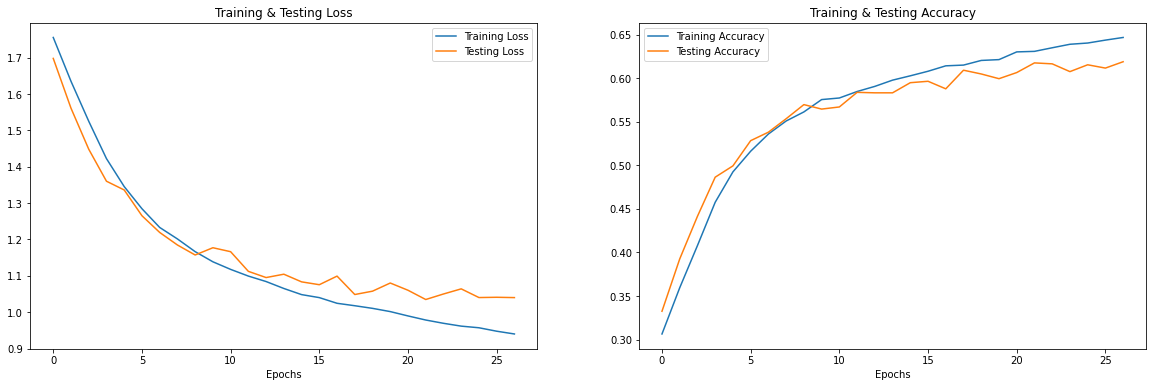

In [70]:
print_report_v3(history, 'categorical_accuracy', 'val_categorical_accuracy')

In [71]:
model.name

'cnn-gru-v9-seq-scale-transpose-16khz'

In [72]:
# mu.save_metrics(model, x_test_scaled, test_basic[1], encoder)

### Predictions

In [73]:
y_pred = model.predict(x_test_scaled)
y_pred_decoded = encoder.inverse_transform(y_pred)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_decoded.flatten()
df['Actual Labels'] = test_basic_decoded

116/116 [==============================] - 1s 5ms/step


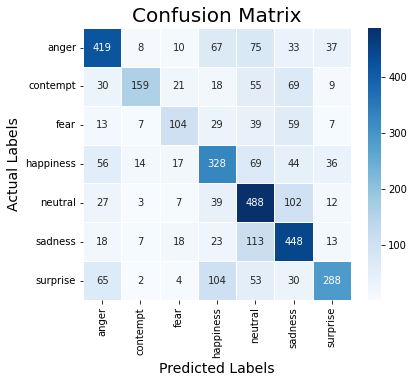

              precision    recall  f1-score   support

       anger       0.67      0.65      0.66       649
    contempt       0.80      0.44      0.57       361
        fear       0.57      0.40      0.47       258
   happiness       0.54      0.58      0.56       564
     neutral       0.55      0.72      0.62       678
     sadness       0.57      0.70      0.63       640
    surprise       0.72      0.53      0.61       546

    accuracy                           0.60      3696
   macro avg       0.63      0.57      0.59      3696
weighted avg       0.62      0.60      0.60      3696



In [74]:
print_confusion_matrix(test_basic_decoded, y_pred_decoded, size=(6, 5))
print(classification_report(test_basic_decoded, y_pred_decoded))

In [66]:
tmp_model_path = f'{model.name}.keras'
print(tmp_model_path)

cnn-gru-v9-seq-scale-transpose-16khz.keras


In [67]:
model.save(tmp_model_path)


In [68]:
new_model = tf.keras.models.load_model(tmp_model_path)


In [69]:
np.testing.assert_allclose(
    model.predict(test_basic[0]), new_model.predict(test_basic[0])
)

116/116 [==============================] - 1s 3ms/step


In [71]:
from save_utils import ModelSaver


In [72]:
saver = ModelSaver(new_model, author="Mykola Nosenko", description="Model to predict emotion by audio", license="", version="v2")


In [73]:
print(model_name)

cnn-gru-v9-seq-scale-transpose-16khz


In [74]:
saver.save_tflite(path=f'saved_models/{model_name}.tflite', 
                  labels_path=r'D:\Programming\nn\emotion_classification\ser_diploma\model\encoder_categories.txt', 
                  i_name='mel', i_desc='64x64 melscpectrogram', 
                  o_name='probabitily', o_desc='probability of one of the emotions')

save model cnn-gru-v9-seq-scale-transpose-16khz to saved_models/cnn-gru-v9-seq-scale-transpose-16khz.tflite


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpaaoko8xr\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpaaoko8xr\assets


In [79]:
y_pred = new_model.predict(x_test_scaled)
y_pred_decoded = encoder.inverse_transform(y_pred)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_decoded.flatten()
df['Actual Labels'] = test_basic_decoded

116/116 [==============================] - 1s 6ms/step


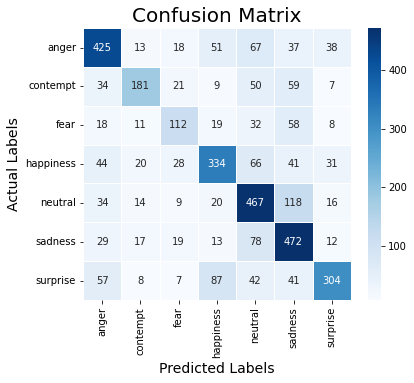

              precision    recall  f1-score   support

       anger       0.66      0.65      0.66       649
    contempt       0.69      0.50      0.58       361
        fear       0.52      0.43      0.47       258
   happiness       0.63      0.59      0.61       564
     neutral       0.58      0.69      0.63       678
     sadness       0.57      0.74      0.64       640
    surprise       0.73      0.56      0.63       546

    accuracy                           0.62      3696
   macro avg       0.63      0.60      0.60      3696
weighted avg       0.63      0.62      0.62      3696



In [81]:
print_confusion_matrix(test_basic_decoded, y_pred_decoded, size=(6,5))
print(classification_report(test_basic_decoded, y_pred_decoded))

In [ ]:
assert(1 == 2)

AssertionError: 

### Tuning

In [ ]:
import keras_tuner as kt

In [ ]:
train_size=len(train_basic[0])
batch_size_=128
epochsH = 100
steps_per_epoch = int(train_size/batch_size_)

In [ ]:
initial_learning_rate, final_learning_rate = 0.002, 0.0001 
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochsH)

lr_1 = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

initial_learning_rate, final_learning_rate = 0.001, 0.0001 
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochsH)

lr_2 = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

initial_learning_rate, final_learning_rate = 0.001, 0.0003 
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochsH)

lr_3 = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)


In [ ]:
def get_model_cv(hp):
    input_shape = (64, 64, 1)
    emotions_number = train_basic[1].shape[1]
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    # model.add(Reshape())
    hp_filters = hp.Int('filters', min_value=8, max_value=64, step=8)
    hp_kernel = hp.Int('kernel', min_value=3, max_value=7, step=2)
    model.add(TimeDistributed(Conv1D(hp_filters, hp_kernel, padding="same", activation='relu', kernel_initializer=initializers.HeUniform(seed=1))))
    model.add(TimeDistributed(AveragePooling1D(3)))
    model.add(TimeDistributed(Flatten()))
    hp_drouput = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    model.add(Dropout(hp_drouput))
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(GRU(hp_units, return_sequences=False))
    model.add(Dense(emotions_number, activation="softmax"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.002])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(get_model_cv,
                     objective='val_categorical_accuracy',
                     max_epochs=20,
                     factor=4,
                     directory=r'D:\Programming\nn\emotion_classification\ser_diploma\model\logs\hypertuning',
                     project_name='cnn_gru_v9')

Reloading Tuner from D:\Programming\nn\emotion_classification\ser_diploma\model\logs\hypertuning\cnn_gru_v9\tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(x_train_scaled, train_basic[1], 
             epochs=100, 
            #  validation_split=0.2,
             validation_data=(x_val_scaled, val_basic[1]), 
             callbacks=[early_stopping, tensorboard_callback])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. Optimal parameters:
      filters: {best_hps.get("filters")}
      kernel: {best_hps.get("kernel")}
      dropout: {best_hps.get("dropout")}
      units: {best_hps.get("units")}
      learning_rate: {best_hps.get("learning_rate")}
""")


The hyperparameter search is complete. Optimal parameters:
      filters: 48
      kernel: 3
      dropout: 0.2
      units: 224
      learning_rate: 0.001



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_best = tuner.hypermodel.build(best_hps)


In [179]:
model_best._name = "cnn-gru-v9-seq-hyper2-scale-transpose-flip-16khz"
print(model_best.name)

cnn-gru-v9-seq-hyper2-scale-transpose-flip-16khz


In [180]:
print(datetime.datetime.now())
history = model_best.fit(x_train_scaled, train_basic[1],
                    epochs=100,
                    batch_size=batch_size_,
                    validation_data=(x_val_scaled, val_basic[1]),
                    callbacks=[early_stopping, tensorboard_callback])

2024-05-10 21:30:17.192331
Epoch 1/100
693/693 [==============================] - 17s 22ms/step - loss: 1.5784 - categorical_accuracy: 0.3843 - val_loss: 1.3158 - val_categorical_accuracy: 0.5032
Epoch 2/100
693/693 [==============================] - 15s 21ms/step - loss: 1.1778 - categorical_accuracy: 0.5607 - val_loss: 1.1140 - val_categorical_accuracy: 0.5874
Epoch 3/100
693/693 [==============================] - 15s 21ms/step - loss: 0.9908 - categorical_accuracy: 0.6308 - val_loss: 1.0415 - val_categorical_accuracy: 0.6144
Epoch 4/100
693/693 [==============================] - 15s 21ms/step - loss: 0.8659 - categorical_accuracy: 0.6771 - val_loss: 1.0034 - val_categorical_accuracy: 0.6301
Epoch 5/100
693/693 [==============================] - 15s 21ms/step - loss: 0.7568 - categorical_accuracy: 0.7195 - val_loss: 1.0246 - val_categorical_accuracy: 0.6374
Epoch 6/100
693/693 [==============================] - 15s 21ms/step - loss: 0.6616 - categorical_accuracy: 0.7563 - val_loss: 1

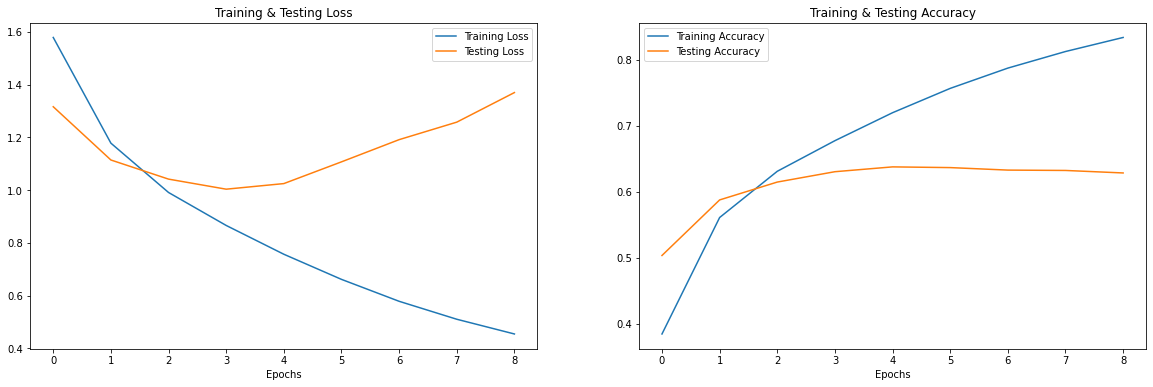

In [181]:
print_report_v3(history, 'categorical_accuracy', 'val_categorical_accuracy')

In [156]:
mu.save_metrics(model, x_test_scaled, test_basic[1], encoder)


116/116 [==============================] - 0s 3ms/step


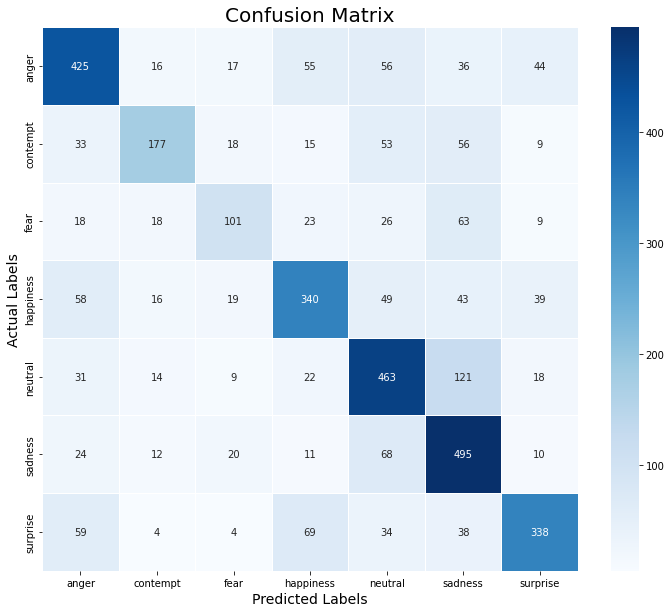

              precision    recall  f1-score   support

       anger       0.66      0.65      0.66       649
    contempt       0.69      0.49      0.57       361
        fear       0.54      0.39      0.45       258
   happiness       0.64      0.60      0.62       564
     neutral       0.62      0.68      0.65       678
     sadness       0.58      0.77      0.66       640
    surprise       0.72      0.62      0.67       546

    accuracy                           0.63      3696
   macro avg       0.63      0.60      0.61      3696
weighted avg       0.64      0.63      0.63      3696



In [157]:
print_confusion_matrix(test_basic_decoded, y_pred_decoded)
print(classification_report(test_basic_decoded, y_pred_decoded))

In [158]:
best_model_path = f'{model_best.name}.keras'
print(best_model_path)

cnn-gru-v9-seq-hyper-scale-transpose-flip-16khz.keras


In [159]:
model_best.save(best_model_path)
new_model_best = tf.keras.models.load_model(best_model_path)

In [160]:
np.testing.assert_allclose(
    model_best.predict(test_basic[0]), new_model_best.predict(test_basic[0])
)

116/116 [==============================] - 1s 4ms/step


In [161]:
saver = ModelSaver(model_best, author="Mykola Nosenko", description="Model to predict emotion by audio", license="", version="v2")


In [162]:
saver.save_tflite(path=f'saved_models/{model_best.name}.tflite', 
                  labels_path=r'D:\Programming\nn\emotion_classification\ser_diploma\model\encoder_categories.txt', 
                  i_name='mel', i_desc='64x64 melscpectrogram', 
                  o_name='probabitily', o_desc='probability of one of the emotions')

save model cnn-gru-v9-seq-hyper-scale-transpose-flip-16khz to saved_models/cnn-gru-v9-seq-hyper-scale-transpose-flip-16khz.tflite


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpz0qsx2ws\assets


INFO:tensorflow:Assets written to: C:\Users\nicko\AppData\Local\Temp\tmpz0qsx2ws\assets


### k fold

In [16]:
train_fold_data = lu.load_encode_single(train_basic_fold_path, encoder)

./features/features-foldtrain-no-uk-mfcc-v4.csv
(10621, 64, 64) (10621, 7)


In [18]:
def get_model_name(k):
    return 'cnn_res_lstm_1905_v1_checkpoint_fold'+str(k)+'.keras'


def get_callbacks(model_file_path):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_path,
                                                    monitor='val_accuracy', verbose=1,
                                                    save_best_only=True, mode='max')
    
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

    return [checkpoint, early_stopping]

In [19]:
train_size = len(train_basic[0])
batch_size_ = 256
initial_learning_rate = 0.001
final_learning_rate = 0.00001
epochsA = 30
epochsS = 150

learning_rate_decay_factor = (
    final_learning_rate / initial_learning_rate)**(1/epochsA)
steps_per_epoch = int(train_size/batch_size_)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

learning_rate_decay_factor = (0.001 / 0.01)**(1/epochsS)
steps_per_epoch = int(train_size/batch_size_)
lr_schedule_sgd = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)

use_sgd = False
if (use_sgd):
    epochs = epochsS
else:
    epochs = epochsA

(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.36846, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 2: val_accuracy improved from 0.36846 to 0.40714, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 3: val_accuracy improved from 0.40714 to 0.41262, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 4: val_accuracy improved from 0.41262 to 0.42092, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold1.keras

Epoch 5: val_accuracy did not improve from 0.42092

Epoch 6: val_accuracy did not improve from 0.42092

Epoch 7: val_accuracy did not improve from 0.42092

Epoch 8: val_accuracy did not improve from 0.42092

Epoch 9: val_accuracy did not improve from 0.42092


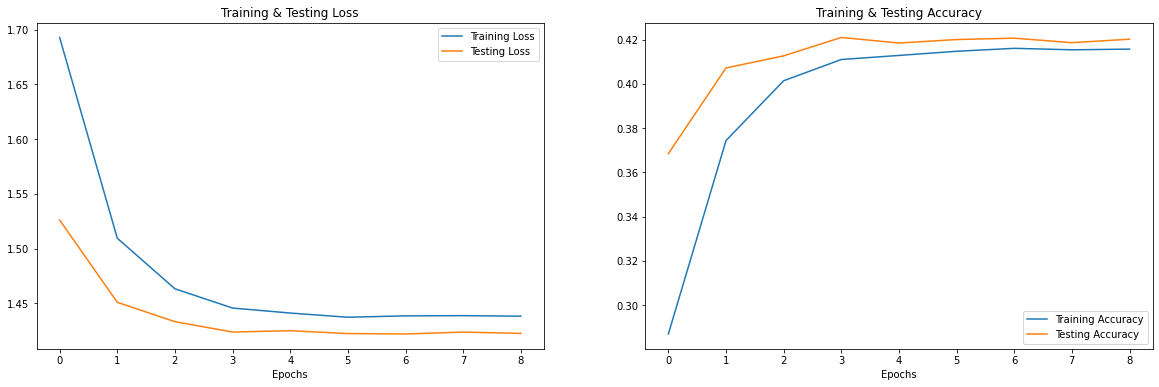

200/200 [==============================] - 3s 14ms/step - loss: 1.4238 - accuracy: 0.4209
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.34581, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 2: val_accuracy improved from 0.34581 to 0.38700, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 3: val_accuracy improved from 0.38700 to 0.39969, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 4: val_accuracy improved from 0.39969 to 0.40940, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 5: val_accuracy improved from 0.40940 to 0.41190, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold2.keras

Epoch 6: val_accuracy did not improve from 0.41190

Epoch 7: val_accuracy improved from 0.41190 to 0.41206, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkp

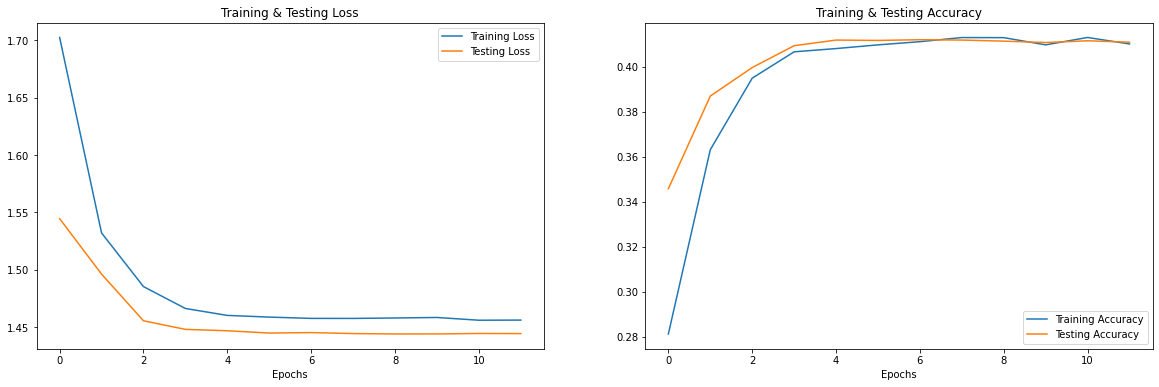

200/200 [==============================] - 2s 9ms/step - loss: 1.4452 - accuracy: 0.4121
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.33187, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 2: val_accuracy improved from 0.33187 to 0.40078, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 3: val_accuracy improved from 0.40078 to 0.40611, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 4: val_accuracy improved from 0.40611 to 0.42396, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold3.keras

Epoch 5: val_accuracy did not improve from 0.42396

Epoch 6: val_accuracy did not improve from 0.42396

Epoch 7: val_accuracy did not improve from 0.42396

Epoch 8: val_accuracy did not improve from 0.42396

Epoch 9: val_accuracy did not improve from 0.42396


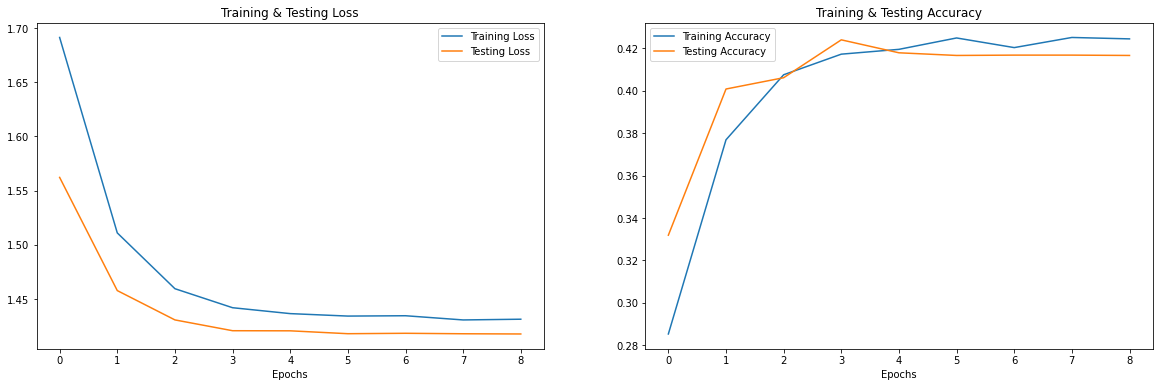

200/200 [==============================] - 2s 9ms/step - loss: 1.4207 - accuracy: 0.4240
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.35756, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 2: val_accuracy improved from 0.35756 to 0.39295, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 3: val_accuracy improved from 0.39295 to 0.41394, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 4: val_accuracy improved from 0.41394 to 0.41629, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 5: val_accuracy improved from 0.41629 to 0.41973, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 6: val_accuracy improved from 0.41973 to 0.42036, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold4.keras

Epoch 7: val_accuracy did not impro

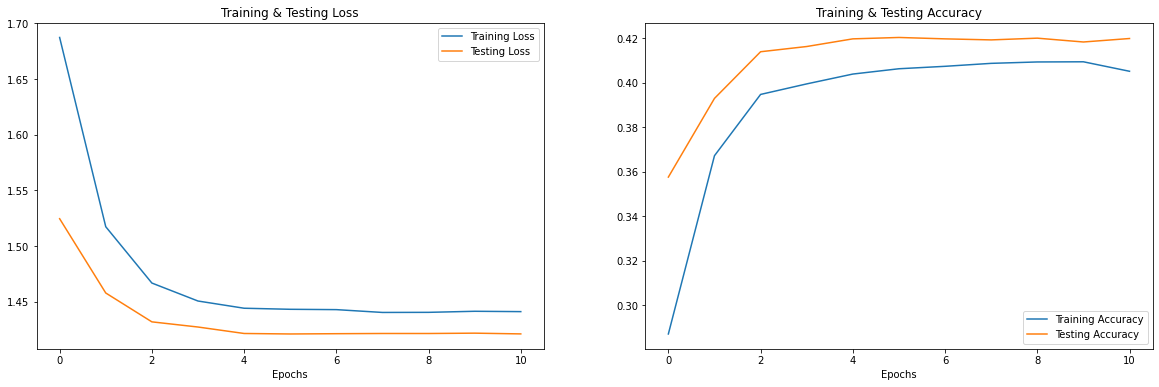

200/200 [==============================] - 2s 8ms/step - loss: 1.4211 - accuracy: 0.4204
(None, 16, 16, 16) (None, 16, 16, 16)

Epoch 1: val_accuracy improved from -inf to 0.35787, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 2: val_accuracy improved from 0.35787 to 0.39405, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 3: val_accuracy improved from 0.39405 to 0.41237, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 4: val_accuracy improved from 0.41237 to 0.41519, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 5: val_accuracy improved from 0.41519 to 0.41691, saving model to k_fold\final_model_foldcnn_res_lstm_1905_v1_checkpoint_fold5.keras

Epoch 6: val_accuracy did not improve from 0.41691

Epoch 7: val_accuracy did not improve from 0.41691

Epoch 8: val_accuracy did not improve from 0.41691

Epoch 9: val_accura

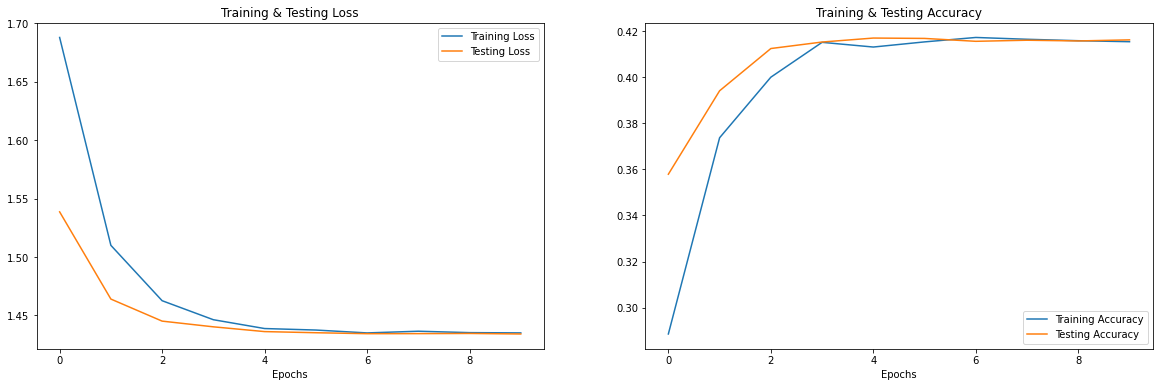

200/200 [==============================] - 3s 16ms/step - loss: 1.4362 - accuracy: 0.4169


In [20]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = 'k_fold/'
fold_var = 1
kfold = KFold(5, shuffle=True, random_state=1)


for train_index, val_index in kfold.split(train_basic[0]):
    training_data = train_basic[0][train_index]
    training_labels = train_basic[1][train_index]
    validation_data = train_basic[0][val_index]
    validation_labels = train_basic[1][val_index]

    # CREATE NEW MODEL
    model = get_model()
    # COMPILE NEW MODEL
    if (use_sgd):
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule_sgd)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy', metrics=['accuracy'])

    # CREATE CALLBACKS
    model_name = save_dir + "final_model_fold" + get_model_name(fold_var)
    callbacks_list = get_callbacks(model_name)


    # FIT THE MODEL
    history = model.fit(training_data, training_labels,
                        epochs=epochs,
                        callbacks=callbacks_list,
                        validation_data=(validation_data, validation_labels), verbose=0)

    # PLOT HISTORY
    print_report_v2(history)

    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(model_name)

    results = model.evaluate(x=validation_data, y=validation_labels)
    results = dict(zip(model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1

In [21]:
VALIDATION_ACCURACY

[0.4209207594394684,
 0.4120595157146454,
 0.42396241426467896,
 0.4203602075576782,
 0.4169146418571472]